GAN(Generative adversarial network)

- GANN은 새로운 이미지나 음성을 만들도록 고안하였고 적대적으로 학습한다. (이미지 생성자와 판별자가 번갈아 경쟁적으로 학습)
- 비지도 학습 방식이다. 
- GAN모듈은 생성자와 판별자라는 주요 모듈 2가지로 구성된다. 
    - 생성자는 무작위 텐서로부터 여러 형태의 가짜 이미지를 생성해낸다. 
    - 판별자는 진짜 이미지와 가짜 이미지를 구분한다. 
    - 학습이 진행되며 생성자는 판별자를 속이기 위해 더 정밀한 가짜 이미지를 생성하며 판별자는 점점 더 잘 구별하게 된다. 
    - 마지막에 생성자는 진짜 이미지와 흡사한 이미지를 만들 수 있게 된다. 

In [18]:
#GAN구현

#라이브러리 임포트
import os 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

#하이퍼 파라미터 설정

EPOCHS = 50
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('다음 장치 이용 :', DEVICE)

#데이터셋 로드 

trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

다음 장치 이용 : cpu


In [19]:
#생성자 판별자 구현 

#생서앚는 정규분포로부터 뽑은 64차원의 무작위 텐서를 입력받아 행렬곱, 활성화함수 연산 실행(ReLU, Tanh)
#무작위 텐서를 입력하는 이유는 생성자가 실제 데이터의 분포를 배우는 것이다. (실제 분포와 비슷해야 한다. )
G = nn.Sequential(nn.Linear(64,256),
                 nn.ReLU(),
                 nn.Linear(256,256),
                 nn.ReLU(),
                 nn.Linear(256,784),
                 nn.Tanh())

#판별자 구현 784차원의 텐서를 입력받고 행렬곱, 활성화 함수 진행 생성자의 이미지가 진짜인지, 가짜이미지인지 구분하는 분류 모델 
#판별자에서는 Leaky ReLu함수 이용 ->음의 기울기도 전달하기 위해서 
D = nn.Sequential(nn.Linear(784,256),
                 nn.LeakyReLU(0.2),
                 nn.Linear(256,256),
                 nn.LeakyReLU(0.2),
                 nn.Linear(256,1),
                 nn.Sigmoid())


In [20]:
#학습구현

#to() 함수로 학습에 쓰일 장치로 보내고, 오차 함수와 최적화 알고리즘 정의 
#진짜 가짜를 판별하는 이진분류이기 때문에 이진교차 엔트로피를 이용하고 Adam 최적화 함수 이용

D = D.to(DEVICE)
G = G.to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002)

In [21]:
#학습 반복문

total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        #진짜 , 가짜 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        #판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        #무작위 텐서 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE) 
        fake_images = G(z)
        
        #판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        #판별자의 오차 계산
        d_loss = d_loss_real +d_loss_fake
        
        #경사 하강법 및 역전파 알고리즘으로 판별자 모델 학습
        d_optimizer.zero_grad() #판별자와 생성자의 기울기 초기화 
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #생성자가 판별자를 속였는지에 대한 오차 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        #역전파 알고리즘으로 생성자 모델 학습 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    #학습진행
    #판별자의 오차 = d_loss // 생성자의 오차 = g_loss // 판별자가 진짜를 진짜로 인식 정확도 = D(x) // 가짜를 진짜로 인식한 정확도 D(G(z))를 통해 학습진행확인
    print('EPOCH : {}/{}  //  d_loss  :  {}  // g_loss :  {}  // D(x) : {}  // D(G(z)) :  {}'.format(
    epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
    


EPOCH : 0/50  //  d_loss  :  0.052031051367521286  // g_loss :  4.613870620727539  // D(x) : 0.9812420010566711  // D(G(z)) :  0.031335171312093735
EPOCH : 1/50  //  d_loss  :  0.0225492175668478  // g_loss :  5.9579668045043945  // D(x) : 0.994870126247406  // D(G(z)) :  0.016872573643922806
EPOCH : 2/50  //  d_loss  :  0.08773685991764069  // g_loss :  5.984992504119873  // D(x) : 0.9793895483016968  // D(G(z)) :  0.021253686398267746
EPOCH : 3/50  //  d_loss  :  0.0700901448726654  // g_loss :  6.199456214904785  // D(x) : 0.9973894357681274  // D(G(z)) :  0.05749407410621643
EPOCH : 4/50  //  d_loss  :  0.154892235994339  // g_loss :  5.309377670288086  // D(x) : 0.9641704559326172  // D(G(z)) :  0.055712971836328506
EPOCH : 5/50  //  d_loss  :  0.24128153920173645  // g_loss :  6.077573776245117  // D(x) : 0.9378468990325928  // D(G(z)) :  0.0375078022480011
EPOCH : 6/50  //  d_loss  :  0.15390586853027344  // g_loss :  5.009391784667969  // D(x) : 0.9636795520782471  // D(G(z)) :

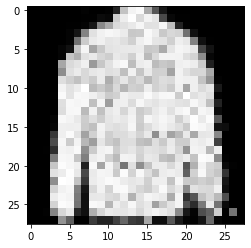

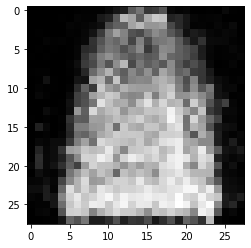

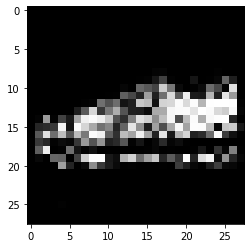

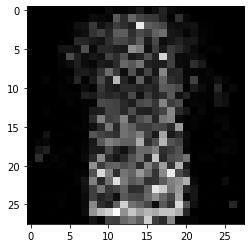

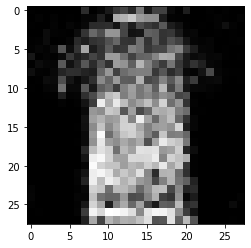

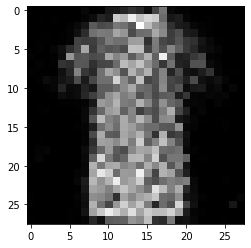

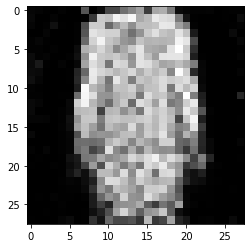

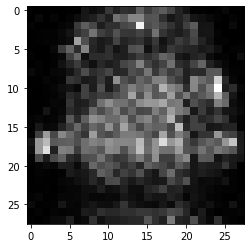

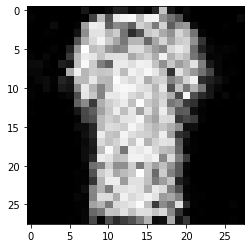

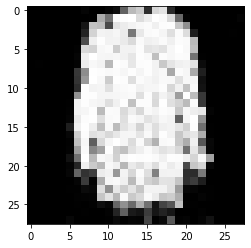

In [22]:
import numpy as np
#생성자가 만든 이미지 시각화
#옷 신발 등의 아이템의 윤곽이 드러났다. 
#EPOCH 횟수를 늘리면 더 좋은 성능이 될 것으로 예상된다. 
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28,28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()